# Sipariş Verisi Analizi ve Servis Alanlarının Belirlenmesi


Açıklamalar

## Metodoloji


## Hazırlık

### Çalışma alanının belirlenmesi


Verileri indirmeden önce, ilgi alanının koordinatlarını tanımlayacağız. Bu koordinatlara dayanarak, veri kümelerini daha ileri işlemeler için kırpabileceğiz ve sonunda seçilen alan için sipariş verisini ve servis alanlarını görüntüleyebileceğiz.

Coğrafi koordinatlar cinsinden bir alanı kolayca tanımlamak için [Bounding Box Tool](https://boundingbox.klokantech.com/) adresine giderek bir bölge seçebilir ve koordinatları alabiliriz. Buradaki değerlerin kullanılabilmesi için sol alt köşeden 'CSV' seçeneğini seçtiğinizden emin olun ve ardından köşeli parantez içindeki değerleri kopyalayın. Koordinatların yanı sıra, grafiklerde ve kaydedilen sonuçlarda kullanılacak alan için bir isim belirtmeniz gerekmektedir. Koordinatların WGS84 koordinat sisteminde (EPSG:4326) belirtilmektedir.


In [1]:
## name of the area
areaname = 'Bursa'
# bbox = [longitude_min, latitude_min, longitude_max, latitude_max]
bbox = [28.0818,39.5695,29.9549,40.645]

## example:
# areaname = 'Istanbul'
# bbox = [28.966667,40.966667,29.216667,41.116667]

### Kütüphanelerin yüklenmesi


Bu not defterinde aşağıdaki Python kütüphanelerini kullanacağız:

- [pandas](https://pandas.pydata.org/) - Tablo şeklindeki verilerle çalışmak için temel bir veri işleme ve analiz kütüphanesidir.
- [geopandas](https://geopandas.org/) - Coğrafi verileri analiz etmek ve görselleştirmek için pandas'ı genişleten bir kütüphane.
- [psycopg2](https://www.psycopg.org/docs/) - PostgreSQL veritabanları ile bağlantı kurmak ve SQL sorguları çalıştırmak için kullanılan bir veritabanı adaptörüdür.
- [plotly](https://plotly.com/python/) - Etkileşimli grafikler, haritalar ve görselleştirmeler oluşturmak için güçlü bir kütüphane.
- [requests](https://docs.python-requests.org/en/latest/) - HTTP istekleri göndermek ve API'lerden veri almak için kullanılan basit ve etkili bir kütüphane.
- [osmnx](https://osmnx.readthedocs.io/en/stable/) - OpenStreetMap verilerini indirip, analiz edip, görselleştirmek için kullanılan bir kütüphane.

Bu kütüphaneler, coğrafi ve sayısal verilerin indirilmesi, işlenmesi, analiz edilmesi ve görselleştirilmesini sağlar.


In [ ]:
# for downloading data and managing files
import os
import requests

# data analysis and table operations
import pandas as pd

# working with geospatial data (shapefile, GeoJSON, etc.)
import geopandas as gpd
from shapely.geometry import box, Polygon, MultiPolygon

# for interactive graphs and map-based visualizations
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.collections import LineCollection
import contextily as ctx

# for downloading, analyzing and visualizing OSM data
import osmnx as ox

0

### Dosya yapısının oluşturulması


In [3]:
# define the folder for the workflow
workflow_folder = 'ORDERS_SERVICE_AREA'

# check if the workflow folder exists, if not, create it
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

In [4]:
# define directories for data and plots within the previously defined workflow folder
data_dir = os.path.join(workflow_folder, f'data_{areaname}')
plot_dir = os.path.join(workflow_folder, f'plots_{areaname}')

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

## Çalışma alanına ait coğrafi verilerin temini ve görüntülenmesi

In [ ]:
# convert bounding box to polygon
def create_bbox_polygon(bbox):
    return box(*bbox)

# download road network or if it's downloaded before, load from file
def get_road_network(bbox, filepath):
    if os.path.exists(filepath):
        print("Yol ağı dosyadan yükleniyor")
        return ox.load_graphml(filepath)
    else:
        print("Yol ağı indiriliyor")
        polygon = create_bbox_polygon(bbox)
        G = ox.graph_from_polygon(polygon, network_type='drive')
        ox.save_graphml(G, filepath)
        return G

# download admin boundaries by area name or if it's downloaded before, load from file
def get_admin_boundaries(area_name, filepath, admin_level=8):
    if os.path.exists(filepath):
        print(f"OSM Admin level {admin_level} sınırları ({area_name}) dosyadan yükleniyor")
        return gpd.read_file(filepath)
    else:
        print(f"OSM Admin level {admin_level} sınırları ({area_name}) indiriliyor")
        
        # İl/ilçe adına göre sınırları çek
        gdf = ox.geocode_to_gdf(area_name, which_result=None)
        
        # Eğer birden fazla sonuç varsa, en uygun olanı seç
        if len(gdf) > 1:
            # Türkiye'deki sonuçları öncelikle
            turkey_results = gdf[gdf['display_name'].str.contains('Turkey|Türkiye', case=False, na=False)]
            if len(turkey_results) > 0:
                gdf = turkey_results.iloc[[0]]  # İlk uygun sonucu al
            else:
                gdf = gdf.iloc[[0]]  # Yoksa genel olarak ilk sonucu al
        
        # Seçilen alanın sınırlarını al
        polygon = gdf.geometry.iloc[0]
        
        # Bu alan içindeki admin_level sınırlarını çek
        tags = {'boundary': 'administrative', 'admin_level': str(admin_level)}
        
        try:
            admin_gdf = ox.features_from_polygon(polygon, tags)
            
            # fazlalık sütunların temizlenmesi
            columns_to_keep = ['name', 'admin_level', 'geometry']
            existing_columns = [col for col in columns_to_keep if col in admin_gdf.columns]
            admin_gdf = admin_gdf[existing_columns]
            
            # geometry sütunu boş olan satırların silinmesi
            admin_gdf = admin_gdf.dropna(subset=['geometry'])
            
            admin_gdf.to_file(filepath)
            return admin_gdf
            
        except Exception as e:
            print(f"Hata: {area_name} için admin_level {admin_level} verileri alınamadı: {e}")
            return gpd.GeoDataFrame()
        
# ilce ve mahallelerdeki noktaların silinmesi
def keep_only_polygons(gdf):
    return gdf[gdf.geometry.apply(lambda g: isinstance(g, (Polygon, MultiPolygon)))].copy()

# sınırların ve yolların görselleştirilmesi
def plot_boundaries(districts, neighborhoods, roads, area_name, bbox):
    fig, ax = plt.subplots(figsize=(8, 8))

    # metrik bir islem olmayacaksa 4326 kalabilir ?
    use_crs = 'EPSG:4326'

    # ilce
    if not districts.empty:
        districts = keep_only_polygons(districts).to_crs(use_crs)
        districts.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, alpha=0.7, label='Districts')

    # mahalle
    if not neighborhoods.empty:
        neighborhoods = keep_only_polygons(neighborhoods).to_crs(use_crs)
        neighborhoods.plot(ax=ax, color='#FAD7A0', edgecolor='black', alpha=0.05, label='Neighborhoods')

    # yol
    if roads is not None:
        edges = ox.graph_to_gdfs(roads, nodes=False, edges=True).to_crs(use_crs)
        edges['geometry'] = edges['geometry'].simplify(0.0005)

        road_styles = {
            'motorway':  {'color': '#E74C3C', 'lw': 1.8},
            'trunk':     {'color': '#D35400', 'lw': 1.4},
            'primary':   {'color': '#F1C40F', 'lw': 1.0},
        }

        for road_type, style in road_styles.items():
            subset = edges[edges['highway'] == road_type]
            lines = [list(geom.coords) for geom in subset.geometry if geom.geom_type == "LineString"]
            if lines:
                lc = LineCollection(lines, colors=style['color'], linewidths=style['lw'], alpha=0.8, label=road_type.capitalize())
                ax.add_collection(lc)

    # cerceve
    bbox_geom = box(*bbox)
    bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_geom], crs='EPSG:4326')
    minx, miny, maxx, maxy = bbox_gdf.total_bounds
    x_buffer = (maxx - minx) * 0.02
    y_buffer = (maxy - miny) * 0.02
    ax.set_xlim(minx - x_buffer, maxx + x_buffer)
    ax.set_ylim(miny - y_buffer, maxy + y_buffer)

    # koordinat gridi ve eksenler
    ax.set_xlabel("Enlem")
    ax.set_ylabel("Boylam")
    ax.tick_params(axis='both', which='major', labelsize=9)

    # legend
    legend_elements = [
        mlines.Line2D([], [], color='black', lw=2, label='İlçe Sınırları'),
        mlines.Line2D([], [], color='black', lw=1, label='Mahalle Sınırları'),
        mlines.Line2D([], [], color='#E74C3C', lw=2, label='Otoyol'),
        mlines.Line2D([], [], color='#D35400', lw=1.5, label='Ekspres Yol'),
        mlines.Line2D([], [], color='#F1C40F', lw=1.2, label='Yol'),
    ]
    ax.legend(handles=legend_elements, loc='lower left', fontsize=9, frameon=True)

    # title
    ax.set_title(f"OpenStreetMap {area_name} bölgesi verileri", fontsize=15, fontweight='bold', color='#2C3E50', pad=15)
    #basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    plt.tight_layout()
    # export it to plot_dir
    plt.savefig(os.path.join(plot_dir, f'{area_name}_osm_boundaries.png'), dpi=600, bbox_inches='tight')
    plt.show()

# main workflow
def analyze_area(bbox, area_name, data_folder=data_dir, plots_folder=plot_dir):
    
    os.makedirs(data_folder, exist_ok=True)
    os.makedirs(plots_folder, exist_ok=True)
    
    # setting file paths
    road_file = os.path.join(data_folder, f'{area_name}_roads.graphml')
    districts_file = os.path.join(data_folder, f'{area_name}_districts.geojson')
    neighborhoods_file = os.path.join(data_folder, f'{area_name}_neighborhoods.geojson')
    
    print(f"{area_name} bölgesi için veri yükleniyor")
    print("-" * 50)
    
    # yollar (bbox ile kapsam alanı artıyor)
    roads = get_road_network(bbox, road_file)
    
    # bolge idari sinirlar
    districts = get_admin_boundaries(area_name, districts_file, admin_level=6)  
    neighborhoods = get_admin_boundaries(area_name, neighborhoods_file, admin_level=8) 
    
    print(f"Veri Özeti:")
    print(f"- Yollar: {len(roads.nodes)} düğüm, {len(roads.edges)} kenar")
    print(f"- İlçeler: {len(districts)} öğe")
    print(f"- Mahalleler: {len(neighborhoods)} öğe")
    
    # data vis
    plot_boundaries(districts, neighborhoods, roads, area_name, bbox)
    
    return roads, districts, neighborhoods

# sample usage
# roads, districts, neighborhoods = analyze_area(bbox, area_name)

Bursa bölgesi için veri yükleniyor
--------------------------------------------------
Yol ağı dosyadan yükleniyor
OSM Admin level 6 sınırları (Bursa) dosyadan yükleniyor


d:\getir-case\.venv\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Several features with id = 223172 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


OSM Admin level 8 sınırları (Bursa) dosyadan yükleniyor


d:\getir-case\.venv\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Several features with id = 223172 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


Veri Özeti:
- Yollar: 89580 düğüm, 247718 kenar
- İlçeler: 2545 öğe
- Mahalleler: 2547 öğe


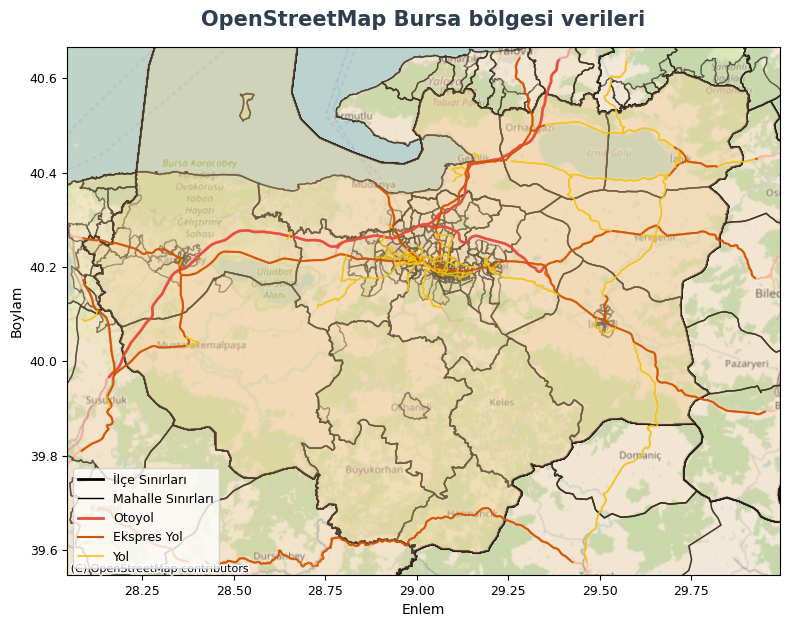

In [6]:
roads, districts, neighborhoods = analyze_area(bbox, areaname)

## Çalışma alanına ait demografik verilerin temini

31 ARALIK 2024 TARİHLİ ADRESE DAYALI NÜFUS KAYIT SİSTEMİ (ADNKS) SONUÇLARI

In [7]:
url = 'https://biruni.tuik.gov.tr/medas/zkau/view/z_9cz/dwnmed-1/pqd/95.xlsx'
file_path = data_dir + '/ADNKSS_2024.xlsx'
headers = {
    ## https://biruni.tuik.gov.tr/medas/?kn=95&locale=tr adresine giderek manuel şekilde de indirebiliriz
    'cookie': 'JSESSIONID=viFvACCF7jmlMJYbS_iAIgne; Tuik=AAI7wmRtaDshiE4AAAAAADu7_G2W2dYNwzIsOxB7EcvF8RTc54MOmVsO5C7uo8EaOw==S2htaA==5QHt6dQcWc2wEmC0doLZYAqn7zA=; TuikPRSa=1116a3db7c9fa04b8f1837b9d8dbf78a4077ec813faf6a85bb41a798277bf55558d2925b; TuikPRSh=7ce2a3d9f7ca587a54dbc07afc822dffcde9c2fe8bcf53c91cfdb78b37afca706b0f747b; Tuik_.tuik.gov.tr_%2F_wlf=AAAAAAXwupFW0ZHb6vhAgO1yx-qPITUw2W4x_Ab6Ic9WKOi-irTBkhILCsbyErtsZ4sQC3SlZ3v6JPThHlYpgM_hxG0O&; Tuik_.tuik.gov.tr_%2F_wat=AAAAAAVaEuBlXsrxGxLw-ZfWmj9pdL2sC8rIvlsQtzUYz7Wn04Okh-wc_09tDOUAq51XGfjmQw3UxRe7dXonZHq8-f_q&',
    'host': 'biruni.tuik.gov.tr',
    'referer': 'https://biruni.tuik.gov.tr/medas/?kn=95&locale=tr',

}

if not os.path.exists(file_path):
    print('TUIK verisi indiriliyor')
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        with open(file_path, 'wb') as f:
            f.write(response.content)
        print('Veri indirildi')
    else:
        print(f'Veri indirilemedi. Durum kodu: {response.status_code}')
else:
    print('Veri zaten var. İndirme atlanıyor.')

# excel -> dataframe
try:
    adnks_df = pd.read_excel(file_path)
    print('ADNKS verisi okundu.')
except Exception as e:
    print(f'Excel dosyası okunamadı: {e}')


Veri zaten var. İndirme atlanıyor.
ADNKS verisi okundu.


### Verinin çalışma alanına uygun hale getirilmesi

## Sipariş ve Depo Verilerinin Temini

Sipariş verisi okundu.
Depo verisi okundu.


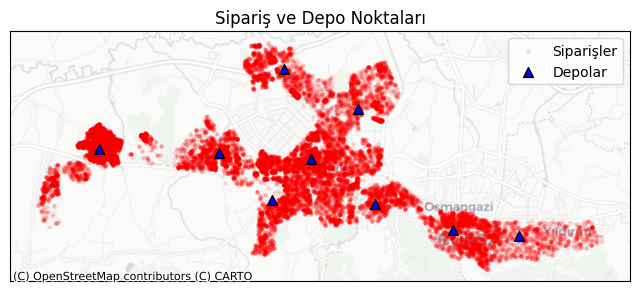

In [ ]:
def load_data(path, name):
    try:
        df = pd.read_csv(path)
        print(f'{name} verisi okundu.')
        return df
    except Exception as e:
        print(f'{name} verisi okunamadı: {e}')
        return None

def find_coords(df):
    cols = {col.lower(): col for col in df.columns}
    try:
        return cols['longitude'], cols['latitude']
    except KeyError:
        raise KeyError(f"{df} verisinde 'longitude' ve/veya 'latitude' kolonları bulunamadı.")

siparis_df = load_data('../data/siparis.csv', 'Sipariş')
warehouse_df = load_data('../data/warehouse.csv', 'Depo')

if siparis_df is not None and warehouse_df is not None:
    s_long, s_lat = find_coords(siparis_df)
    w_long, w_lat = find_coords(warehouse_df)

    siparis_gdf = gpd.GeoDataFrame(siparis_df, geometry=gpd.points_from_xy(siparis_df[s_long], siparis_df[s_lat]), crs="EPSG:4326").to_crs(epsg=3857)
    warehouse_gdf = gpd.GeoDataFrame(warehouse_df, geometry=gpd.points_from_xy(warehouse_df[w_long], warehouse_df[w_lat]), crs="EPSG:4326").to_crs(epsg=3857)

    ax = siparis_gdf.plot(figsize=(8, 8), markersize=5, color='red', label='Siparişler', alpha=0.1)
    warehouse_gdf.plot(ax=ax, markersize=50, color='blue', marker='^', label='Depolar', edgecolor='k')
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    # 3857 projeksiyonu için eksen etiketlerini kaldır
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.legend()
    plt.title('Sipariş ve Depo Noktaları')
    plt.show()

